# NLP Project 2 - Sara Nordin Hällgren and Adnan Fazlinovic

## Imports

In [89]:
import numpy as np
import pandas as pd
import spacy
nlp = spacy.load('en_core_web_sm')

import time

from numpy import random as rd
from scipy.special import gammaln
from collections import Counter
from collections import defaultdict
from matplotlib import pyplot as plt

# Import stopwords
import nltk
from nltk.corpus import stopwords
stop = stopwords.words('english')

## Corpus setup

### Function definitions

In [256]:
def clean_corpus(corpus:str, encoding:str, nr_tokens:int, stop:list) -> list():
    
    '''
    Only consider 100 000 tokens.
    Removes strings from stopword-list from corpus.
    Removes string with fewer characters than 3.
    Keeps lemmatized words.
    '''
    
    token_count = 0
    docs = list()
    docs_count = 0
    freqs = Counter()  
    
    with open(corpus, encoding = encoding) as f:
        
        while token_count < nr_tokens:
            
            doc = f.readline()
            docs_count += 1
            temp_doc = list()
            
            # Lemmatizion of tokens
            result = nlp(doc.lower(), disable=['tagger', 'parser', 'ner'])
            
            for token in result:
                if len(token.lemma_) > 2:
                    if token.lemma_ not in stop:
                        token_count += 1
                        freqs[token.lemma_] += 1
                        temp_doc.append(token.lemma_)
                        
            docs.append(temp_doc)

    print('Nr of tokens:' + str(token_count))
    print('Nr of docs:' + str(docs_count))
    
    return docs

def map_to_int(docs:list()) -> (list(), int, Counter()):
    
    '''
    Create bag of words from cleaned and smaller corpus.
    Associate each word in bag with an unique integer,
    ranging from 0 (most common word) to length of bag of words.
    Map each token in docs to the respective int. Return this list of list of ints.
    '''
    
    freqs = Counter()
    for doc in docs:
        for token in doc:
            freqs[token] += 1
    most_common = freqs.most_common()
    
    token_to_int = []
    for i in range(len(most_common)):
        token_to_int.append(most_common[i][0])

    # Get pairs of elements    
    mapping = zip(token_to_int, range(0,len(token_to_int)))
    
    # Make pairs into a dictionary
    vocab = dict(mapping)
        
    # Match token to int
    docs_int = list()
    
    for doc in docs:
        docs_int.append(list([vocab.get(x) for x in doc]))
        
    return docs_int, len(vocab), vocab

### Process a subset of the corpus

In [3]:
# Make list of stopwords

stop = list()

for x in stopwords.words('english'):
    stop.append(x)

# Add a couple of more stopwords which were observed manually

for x in ['-PRON-','\n','...','..',"'d'","n't"]:
    stop.append(x)

In [4]:
corpus = 'books.txt'
encoding = 'ISO-8859-1'
M = 10**5   # Corpus size

In [ ]:
docs = clean_corpus(corpus=corpus, encoding=encoding, nr_tokens=M, stop=stop)
docs_int, vocab_size, vocab = map_to_int(docs)
n_docs = len(docs_int)

# For some strange reason, one value in docs_int becomes NaN. 
# As we haven't figured out why, we temporarily set this value to 0.

nan_loc = []

for d, line in enumerate(docs_int):

    for j, w in enumerate(line):
        if w == None:
            nan_loc.append((d, j))
        
docs_int[nan_loc[0][0]][nan_loc[0][1]] = 0

# 1 - Collapsed Gibbs sampling for LDA

## Function definitions

In [12]:
def initialize_lda(docs_int, freqs, n_topics):
    
    n_docs = len(docs_int)
    vocab_size = len(freqs)

    # Number of times that we observe topic z in document d
    ndz = np.zeros((n_docs, n_topics))

    # Number of times that we observe word w in topic z
    nzw = np.zeros((n_topics, vocab_size))

    # Counters for documents and topics
    nd = np.zeros(n_docs)
    nz = np.zeros(n_topics)

    # Create dictionary of topics
    topics = {}

    # iterate over documents 
    for d, line in enumerate(docs_int):
        for i, w in enumerate(line):
                  
            # w = docs_int[d][i] # Numerical rep of word w in doc d

            # Initialise with a random topic
            z = np.random.randint(n_topics)
            topics[(d,i)] = z

            # Increase counters
            ndz[d, z] += 1
            nzw[z, w] += 1

            nd[d] += 1
            nz[z] += 1

    return topics, ndz, nzw, nd, nz

In [13]:
def cond_topic_prob(ndz, nzw, nz, nd, w, d, alpha, beta, n_topics, voc_size):
    """
    Conditional probability of topics. 
    """

    left = (nzw[:,w] + beta) / (nz + beta * voc_size)
    right = (ndz[d,:] + alpha) / (nd[d] + alpha * n_topics)

    p_z = left * right
    p_z /= np.sum(p_z)
    
    return p_z

In [14]:
def log_multinomial_beta(alpha, K=None):

    if K is None:
        # alpha is assumed to be a vector
        return np.sum(gammaln(alpha)) - gammaln(np.sum(alpha))
    else:
        # alpha is assumed to be a scalar
        return K * gammaln(alpha) - gammaln(K*alpha)


In [15]:
def loglikelihood(n_topics, voc_size, alpha, beta, nzw, ndz):
    likelihood = 0
    
    n_docs = ndz.shape[0]
    
    for z in range(n_topics):
        likelihood += log_multinomial_beta(nzw[z,:] + beta)
        likelihood -= log_multinomial_beta(beta, voc_size)
        
    for d in range(n_docs):
        likelihood += log_multinomial_beta(ndz[d,:] + alpha)
        likelihood -= log_multinomial_beta(alpha, n_topics)
        
    return likelihood

In [20]:
def LDA_Gibbs_Sampler(docs_int, voc_size, n_topics, max_iterations, alpha, beta, freqs):

    start_time = time.time()
    log_vec = []
    topics, ndz, nzw, nd, nz = initialize_lda(docs_int, freqs, n_topics)

    for i in range(max_iterations):
        for d, line in enumerate(docs_int):
             for j, w in enumerate(line):
                
                z = topics[(d, j)]
                ndz[d, z] -= 1
                nzw[z, w] -= 1
                nd[d] -= 1
                nz[z] -= 1
            
                # Compute probabilities, and choose a new topic z
                p_z = cond_topic_prob(ndz, nzw, nz, nd, w, d, alpha, beta, n_topics, vocab_size)
                z = np.random.multinomial(1, p_z).argmax() # maybe don't use argmax, use it as a probability
                
                ndz[d,z] += 1
                nzw[z,w] += 1
                nd[d] += 1
                nz[z] += 1
                topics[(d, j)] = z    
        
        if i % 10 == 0:
            print("Iteration", i)
            
            # Calculate log likelihood
            log_l = loglikelihood(n_topics, voc_size, alpha, beta, nzw, ndz)
            log_vec.append(log_l)
            print("Likelihood", log_l)

    elapsed_time = time.time() - start_time
    print("Elapsed time: ", elapsed_time)
    
    return nzw, log_vec

In [17]:
def show_words_by_topic(word_topic_prob, vocabulary, typical_len):
    
    n_topics = word_topic_prob.shape[0]
    typical_words = []

    for i in range(n_topics):
        arr = word_topic_prob[i,:]
        typical_ints = arr.argsort()[-typical_len-2:-2][::-1]   # there's some funny business with the last word in vocab
        #print(typical_ints)

        for search_int in typical_ints:
            if search_int in [0, -1]:
                typical_words.append("")
            else:
                for k, v in vocabulary.items(): 
                    if v == search_int:
                        typical_words.append(k)
                        break

    # Print the most common words in each topic
    typical_words = np.reshape(typical_words, [n_topics, -1])
    print(typical_words)

## Running the code

This is an implementation of collapsed Gibbs sampling for LDA. We run the code with 4 different parameter choices, detailed below. The training progress is visualised with the log-likelihood that the model has generated the current corpus, which is seen to grow over time. The resulting topics are compared by showing a list of the 10 most common words for each topic, by occurence. The algorithm is run for 400 iterations to determine when convergence occurs.

In [ ]:
it = 400    # Nr of iterations

### 10 Topics, $\alpha = \beta = 0.1$

Iteration 0
Likelihood -1032404.0797602335
Iteration 10
Likelihood -923691.7263883833
Iteration 20
Likelihood -903896.2155518925
Iteration 30
Likelihood -893974.7724219951
Iteration 40
Likelihood -889392.2656591529
Iteration 50
Likelihood -885255.2946135086
Iteration 60
Likelihood -883507.2003660903
Iteration 70
Likelihood -880579.0395155222
Iteration 80
Likelihood -878410.5853517882
Iteration 90
Likelihood -877243.6137591964
Iteration 100
Likelihood -874813.2720250909
Iteration 110
Likelihood -872605.8079628327
Iteration 120
Likelihood -870815.219891466
Iteration 130
Likelihood -869247.64045504
Iteration 140
Likelihood -868682.240191625
Iteration 150
Likelihood -868299.0636592628
Iteration 160
Likelihood -867516.9617323613
Iteration 170
Likelihood -865926.6826918499
Iteration 180
Likelihood -864948.0154762262
Iteration 190
Likelihood -863244.3425945294
Iteration 200
Likelihood -861091.3095659362
Iteration 210
Likelihood -859246.315892085
Iteration 220
Likelihood -857986.4077502127
Ite

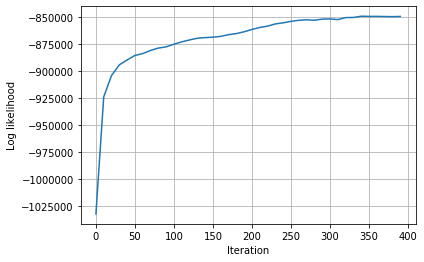

In [122]:
K = 10
alpha = 0.1
beta = alpha

word_topic_prob_01_10, log_lik_01_10 = LDA_Gibbs_Sampler(docs_int, vocab_size, K, it, alpha, beta, freqs)

In [127]:
show_words_by_topic(word_topic_prob_01_10, vocab, 10)

[['story' 'woman' 'reader' 'man' 'jason' 'plot' 'human' 'series' 'murder'
  'sex']
 ['mother' 'family' 'old' 'dog' 'young' 'father' 'life' 'man' 'year'
  'school']
 ['history' 'sam' 'news' 'political' 'government' 'country' 'account'
  'america' 'state' 'military']
 ['translation' 'cat' 'language' 'funny' 'use' 'word' 'introduction'
  'name' 'dictionary' 'english']
 ['good' 'use' 'work' 'many' 'think' 'write' 'student' 'example' 'make'
  'understand']
 ['food' 'eat' 'include' 'plant' 'cook' 'find' 'look' 'guide' 'diet'
  'garden']
 ['norris' 'play' 'money' 'school' 'team' 'real' 'mcginnis' 'mcdonald'
  'estate' 'rich']
 ['music' 'mean' 'art' 'artist' 'contemporary' 'student' 'journey'
  'pattern' 'original' 'cell']
 ['smith' 'church' 'prospero' 'modern' 'horse' 'machine' 'science'
  'spiritual' 'ancient' 'man']
 ['much' 'one' 'like' 'good' 'would' 'time' 'get' 'write' 'make' 'find']]


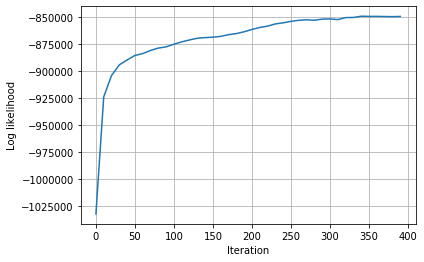

In [128]:
plt.plot(range(0, it, 10), log_lik_01_10)
plt.grid(True)
plt.xlabel("Iteration")
plt.ylabel("Log likelihood")
plt.show()

We notice that the log-likelihood converges after around 350 iterations. The 10 most common words in each topic are:

- ['story' 'woman' 'reader' 'man' 'jason' 'plot' 'human' 'series' 'murder' 'sex']
- __['mother' 'family' 'old' 'dog' 'young' 'father' 'life' 'man' 'year' 'school']__
- __['history' 'sam' 'news' 'political' 'government' 'country' 'account' 'america' 'state' 'military']__
- ['translation' 'cat' 'language' 'funny' 'use' 'word' 'introduction' 'name' 'dictionary' 'english']
- ['good' 'use' 'work' 'many' 'think' 'write' 'student' 'example' 'make' 'understand']
- __['food' 'eat' 'include' 'plant' 'cook' 'find' 'look' 'guide' 'diet' 'garden']__
- ['norris' 'play' 'money' 'school' 'team' 'real' 'mcginnis' 'mcdonald' 'estate' 'rich']
- ['music' 'mean' 'art' 'artist' 'contemporary' 'student' 'journey' 'pattern' 'original' 'cell']
- ['smith' 'church' 'prospero' 'modern' 'horse' 'machine' 'science' 'spiritual' 'ancient' 'man']
- ['much' 'one' 'like' 'good' 'would' 'time' 'get' 'write' 'make' 'find']

Some of these topics are quite generic, and some of them contain less common words but in questionable groupings. However three of the topics (in bold) appear to make sense. One topic appears to be related to families, one to politics, and one to food and diets. 

### 50 Topics, $\alpha = \beta = 0.1$

Iteration 0
Likelihood -1182689.14752616
Iteration 10
Likelihood -994990.689248799
Iteration 20
Likelihood -951603.0399049424
Iteration 30
Likelihood -927141.0115349921
Iteration 40
Likelihood -915381.3917071999
Iteration 50
Likelihood -906532.8434499218
Iteration 60
Likelihood -899585.6598606339
Iteration 70
Likelihood -895585.097808803
Iteration 80
Likelihood -893333.3523915298
Iteration 90
Likelihood -891457.5222107462
Iteration 100
Likelihood -889679.6335538579
Iteration 110
Likelihood -890258.88566321
Iteration 120
Likelihood -887487.047747247
Iteration 130
Likelihood -887162.7629106794
Iteration 140
Likelihood -887365.1008180174
Iteration 150
Likelihood -886587.0906295455
Iteration 160
Likelihood -886041.7132673647
Iteration 170
Likelihood -885989.9339772859
Iteration 180
Likelihood -885550.655989997
Iteration 190
Likelihood -886269.3361995897
Iteration 200
Likelihood -884740.4917677735
Iteration 210
Likelihood -884604.607452892
Iteration 220
Likelihood -885379.9187646321
Iterati

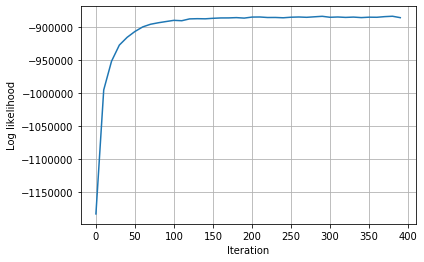

In [123]:
K = 50
alpha = 0.1
beta = alpha

word_topic_prob_01_50, log_lik_01_50 = LDA_Gibbs_Sampler(docs_int, vocab_size, K, it, alpha, beta, freqs)

In [129]:
show_words_by_topic(word_topic_prob_01_50, vocab, 10)

[['religious' 'evidence' 'worship' 'dirk' 'claim' 'warn' 'computer'
  'morton' 'probability' 'technology']
 ['mcginnis' 'mcdonald' 'nature' 'nightjohn' 'another' 'man' 'ethic'
  'theory' 'slave' 'though']
 ['much' 'story' 'one' 'good' 'like' 'character' 'love' 'get' 'would'
  'time']
 ['medium' 'team' 'reporter' 'aid' 'numb' 'wilson' 'steve' 'liberal'
  'york' 'disaster']
 ['corp' 'hmong' 'culture' 'river' 'pakistan' 'ebay' 'critic' 'meaker'
  'levee' 'katrina']
 ['community' 'historical' 'bible' 'pray' 'christian' 'vampire' 'pope'
  'release' 'hal' 'prophecy']
 ['god' 'whitman' 'coast' 'captain' 'dick' 'literary' 'ash' 'poem' 'bud'
  'weaver']
 ['mike' 'howard' 'conan' 'dozen' 'plague' 'horton' 'wyoh' 'anna'
  'outstanding' 'colony']
 ['card' 'invest' 'rich' 'financial' 'success' 'oil' 'poor' 'gay'
  'millionaire' 'message']
 ['testament' 'cameron' 'alpha' 'mann' 'dictionary' 'wolf' 'yapko'
  'participant' 'power' 'foster']
 ['map' 'space' 'wine' 'security' 'historian' 'pack' 'trip' '

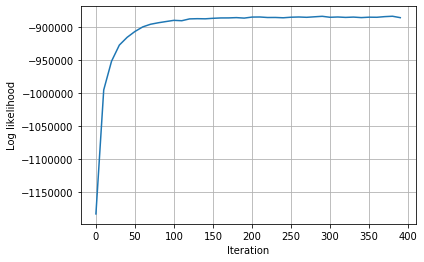

In [130]:
plt.plot(range(0, it, 10), log_lik_01_50)
plt.grid(True)
plt.xlabel("Iteration")
plt.ylabel("Log likelihood")
plt.show()

We notice that the log-likelihood converges much elarlier, after around 150 iterations. However the final value of the log-likelihood is about the same as in the previous setting. Some of the topics that appear to make the most sense are:

- ['community' 'historical' 'bible' 'pray' 'christian' 'vampire' 'pope' 'release' 'hal' 'prophecy']
- ['card' 'invest' 'rich' 'financial' 'success' 'oil' 'poor' 'gay' 'millionaire' 'message']
- ['america' 'political' 'country' 'military' 'government' 'president' 'show' 'power' 'society' 'u.s']
- ['player' 'british' 'football' 'hell' 'high' 'group' 'ludlum' 'carry' 'american' 'poker']
- ['man' 'body' 'female' 'orgasm' 'lawrence' 'pregnant' 'sexual' 'hilda' 'seem' 'immigrant']
- ['highet' 'school' 'teach' 'mathematics' 'theory' 'expert' 'engineer' 'art' 'evidence' 'test']
- ['discworld' 'hike' 'magic' 'wizard' 'hogfather' 'hansen' 'irene' 'leaf' 'pratchett' 'granny']
- ['artist' 'art' 'movement' 'quartet' 'client' 'nietzsche' 'poem' 'rock' 'christian' 'thinker']
- ['organization' 'decision' 'customer' 'development' 'management' 'pattern' 'profit' 'market' 'software' 'provide']
- ['asher' 'red' 'army' 'man' 'account' 'hitler' 'german' 'soldier' 'abdulin' 'jews']

However, most of the topics generated are still a bit vague or just don't make sense. An interesting thing that occurs this far along in training is that a lot of names start appearing - this is most likely references to authors or characters in the books. Since first and last names have been separated, it's in most cases no longer possible to determine whether these references to people make sense within a topic or not. Possibly it would have been better to identify named entities first in the corpus, and then merge their names into one word. 

### 10 Topics, $\alpha = \beta = 0.01$

Iteration 0
Likelihood -1068852.1747088158
Iteration 10
Likelihood -935907.679862206
Iteration 20
Likelihood -920018.5906413506
Iteration 30
Likelihood -912786.378300575
Iteration 40
Likelihood -907738.5022175435
Iteration 50
Likelihood -903531.5800999552
Iteration 60
Likelihood -900719.083867321
Iteration 70
Likelihood -898076.824728633
Iteration 80
Likelihood -896442.2705336084
Iteration 90
Likelihood -894831.5177883953
Iteration 100
Likelihood -893553.9327822812
Iteration 110
Likelihood -892101.2898480312
Iteration 120
Likelihood -890453.920928218
Iteration 130
Likelihood -889432.3339442007
Iteration 140
Likelihood -887899.1890265131
Iteration 150
Likelihood -886369.8357966606
Iteration 160
Likelihood -886076.8808425341
Iteration 170
Likelihood -885060.9975182969
Iteration 180
Likelihood -883802.7052039274
Iteration 190
Likelihood -883258.382819362
Iteration 200
Likelihood -882560.2420944609
Iteration 210
Likelihood -882017.2330215132
Iteration 220
Likelihood -881775.2706920732
Iter

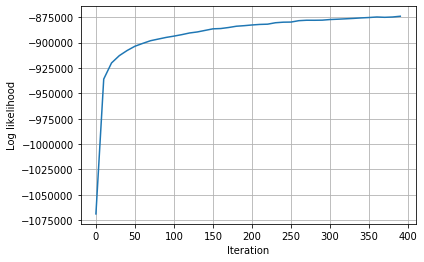

In [124]:
K = 10
alpha = 0.01
beta = alpha

word_topic_prob_001_10, log_lik_001_10 = LDA_Gibbs_Sampler(docs_int, vocab_size, K, it, alpha, beta, freqs)

In [131]:
show_words_by_topic(word_topic_prob_001_10, vocab, 10)

[['like' 'say' 'author' 'one' 'get' 'much' 'even' 'know' 'see' 'make']
 ['sam' 'family' 'novel' 'death' 'take' 'old' 'year' 'love' 'character'
  'live']
 ['character' 'work' 'love' 'one' 'series' 'world' 'plot' 'fiction'
  'tale' 'mystery']
 ['real' 'include' 'food' 'day' 'erica' 'year' 'three' 'mention' 'eat'
  'cook']
 ['world' 'much' '' 'great' 'live' 'self' 'many' 'people' 'experience'
  'work']
 ['man' 'love' 'god' 'play' 'one' 'make' 'also' 'doe' 'become' 'another']
 ['good' 'use' 'read' 'make' 'great' 'work' 'would' 'take' 'think' 'also']
 ['write' 'much' 'read' 'time' 'many' 'little' 'reader' 'find' 'good'
  'work']
 ['much' 'one' 'good' 'would' 'like' 'get' 'find' 'time' 'well' 'write']
 ['human' 'american' 'world' 'much' 'state' 'account' 'interest' 'show'
  'power' 'understand']]


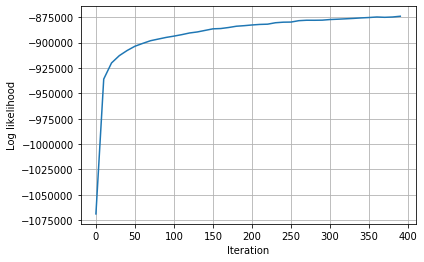

In [132]:
plt.plot(range(0, it, 10), log_lik_001_10)
plt.grid(True)
plt.xlabel("Iteration")
plt.ylabel("Log likelihood")
plt.show()

Here, we notice that the log-likelihood converges more slowly - after 400 iterations it has barely finished increasing. One could run with these settings for longer, maybe 600 iterations, to see if it converges then. The 10 most common words in each topic are:

- ['like' 'say' 'author' 'one' 'get' 'much' 'even' 'know' 'see' 'make']
- ['sam' 'family' 'novel' 'death' 'take' 'old' 'year' 'love' 'character' 'live']
- ['character' 'work' 'love' 'one' 'series' 'world' 'plot' 'fiction' 'tale' 'mystery']
- __['real' 'include' 'food' 'day' 'erica' 'year' 'three' 'mention' 'eat' 'cook']__
- __['world' 'much' '' 'great' 'live' 'self' 'many' 'people' 'experience' 'work']__
- ['man' 'love' 'god' 'play' 'one' 'make' 'also' 'doe' 'become' 'another']
- ['good' 'use' 'read' 'make' 'great' 'work' 'would' 'take' 'think' 'also']
- ['write' 'much' 'read' 'time' 'many' 'little' 'reader' 'find' 'good' 'work']
- ['much' 'one' 'good' 'would' 'like' 'get' 'find' 'time' 'well' 'write']
- __['human' 'american' 'world' 'much' 'state' 'account' 'interest' 'show' 'power' 'understand']__

Like before, most topics are determined to not make much sense. However three of them do show good patterns: one seems to be based on food, one on people, and another on politics. It seems like one can't get enough resolution when asking for just 10 topics - or maybe different parameter values would help.

### 50 Topics, $\alpha = \beta = 0.01$

Iteration 0
Likelihood -1190341.111029679
Iteration 10
Likelihood -950401.2821342411
Iteration 20
Likelihood -927367.9264104791
Iteration 30
Likelihood -917806.0971874195
Iteration 40
Likelihood -911120.8866987126
Iteration 50
Likelihood -906899.6797617208
Iteration 60
Likelihood -903555.7031819011
Iteration 70
Likelihood -900429.6007665116
Iteration 80
Likelihood -897869.6554888989
Iteration 90
Likelihood -894549.8423284735
Iteration 100
Likelihood -893586.4005781844
Iteration 110
Likelihood -892401.8520005256
Iteration 120
Likelihood -891057.567225403
Iteration 130
Likelihood -889910.6543435233
Iteration 140
Likelihood -888308.3497488376
Iteration 150
Likelihood -887279.2544167578
Iteration 160
Likelihood -885880.0628348708
Iteration 170
Likelihood -884349.6007468438
Iteration 180
Likelihood -883633.8959385153
Iteration 190
Likelihood -882571.7150303713
Iteration 200
Likelihood -882349.1190868967
Iteration 210
Likelihood -881592.7386724561
Iteration 220
Likelihood -880876.0226334232


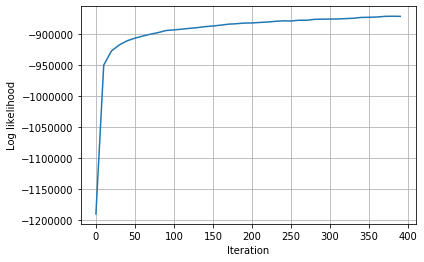

In [125]:
K = 50
alpha = 0.01
beta = alpha

word_topic_prob_001_50, log_lik_001_50 = LDA_Gibbs_Sampler(docs_int, vocab_size, K, it, alpha, beta, freqs)

In [133]:
show_words_by_topic(word_topic_prob_001_50, vocab, 10)

[['much' 'good' 'like' 'write' 'give' 'get' 'make' 'great' 'love' 'one']
 ['need' 'figure' 'oil' 'place' 'fan' 'must' 'every' 'god' '' 'change']
 ['faith' 'transformation' 'never' 'community' 'social' 'dimension'
  'brilliant' 'europe' 'snake' '....']
 ['doe' 'take' 'hundred' 'note' 'set' 'greek' 'anne' 'upon' 'british'
  'classic']
 ['military' 'political' 'much' 'soviet' 'show' 'america' 'bush'
  'vietnam' 'world' 'country']
 ['school' 'young' 'love' 'see' 'year' 'old' 'adult' 'kid' 'one' 'parent']
 ['use' 'plant' 'another' 'common' 'real' 'illustration' 'color' 'plan'
  'pattern' 'provide']
 ['experience' 'personal' 'offer' 'spiritual' 'family' 'use' 'grow'
  'dream' 'land' 'race']
 ['read' 'know' 'one' 'time' 'today' 'take' 'make' 'believe' 'life'
  'want']
 ['reader' 'interest' 'piece' 'culture' 'one' 'west' 'use' 'part'
  'english' 'language']
 ['translation' 'original' 'rise' 'vampire' 'master' 'full' 'name'
  'chinese' 'heaven' 'word']
 ['collection' 'gibbon' 'make' 'without' '

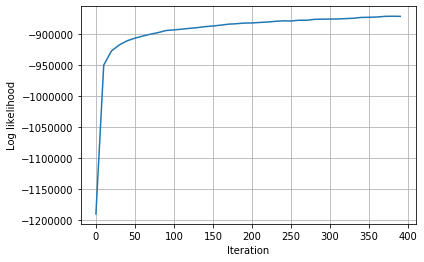

In [134]:
plt.plot(range(0, it, 10), log_lik_001_50)
plt.grid(True)
plt.xlabel("Iteration")
plt.ylabel("Log likelihood")
plt.show()

Here, we also notice that the algorithm has barely converged after 400 iterations. It appears that a lower value for $\alpha$ and $\beta$ can be linked to slower convergence of the algorithm. The topics that appear to make the most sense are:

- ['military' 'political' 'much' 'soviet' 'show' 'america' 'bush' 'vietnam' 'world' 'country']
- ['eat' 'cook' 'diet' 'meal' 'include' 'weight' 'cookbook' 'fat' 'healthy' 'ingredient']
- ['machine' 'ancient' 'truth' 'brain' 'idea' 'think' 'model' 'reason' 'self' 'von']
- ['mother' 'family' 'boy' 'learn' 'grow' 'father' 'name' 'want' 'man' 'die']

Many other topics have a tendency to make a bit of sense - for example this one includes 'pregnant' and 'woman', but the other words make less sense:

- ['woman' 'age' 'nothing' 'talk' 'god' 'experience' 'say' 'music' 'reviewer' 'pregnant']

Overall, we get much fewer good topics in the setting where $\alpha = \beta = 0.01$, which could be linked to the slow convergence we discussed earlier. Maybe if the algorithm was run much longer with these hyperparameters, it would eventually converge.  

### Save results as csv

In [126]:
np.savetxt("nzw_01_10.csv", word_topic_prob_01_10, delimiter=",")
np.savetxt("nzw_01_50.csv", word_topic_prob_01_50, delimiter=",")
np.savetxt("nzw_001_10.csv", word_topic_prob_001_10, delimiter=",")
np.savetxt("nzw_001_50.csv", word_topic_prob_001_50, delimiter=",")

# 2 - Gibbs sampling for LDA

## Function definitions

In [265]:
def init_lda(docs:list(), n_docs:int, n_topics:int, vocab_size:int) -> (np.matrix, np.matrix, np.matrix):
    
    # \Theta
    theta = np.zeros((n_docs,n_topics))
    for d in range(n_docs):
        theta[d] = np.random.dirichlet(alpha * np.ones(n_topics))

    # \phi
    phi = np.zeros((n_topics, vocab_size))
    for z in range(n_topics):
        phi[z] = np.random.dirichlet(beta*np.ones(vocab_size))
    
    # Word topic assignment
    Z_dj = list()
    for d in range(n_docs):
        Z_dj.append([0]*len(docs[d]))
    
    # Init wt by randomly assigning topics to each word in corpus
    for d in range(n_docs):
        for j in range(len(docs[d])):
            Z_dj[d][j] = np.random.randint(n_topics) # Generate random topic
        
    return theta, phi, Z_dj

def update(docs, Z_dj, n_docs, n_topics, vocab_size, theta, phi):
    
    # Counter for word j in document d
    nd = np.zeros((n_docs, n_topics))
    mk = np.zeros((n_topics, vocab_size))
    
    for d in range(n_docs):
        for j in range(len(docs[d])):
            nd[d][Z_dj[d][j]] += 1
            mk[Z_dj[d][j]][docs[d][j]] += 1
            
    return nd, mk

In [266]:
def gibbs(docs:list(), n_docs:int, n_topics:int, vocab:dict(), vocab_size:int, max_iterations:int, alpha:int, beta:int):

    start_time = time.time()
    theta, phi, Z_dj = init_lda(docs, n_docs=n_docs, n_topics=n_topics, vocab_size=vocab_size)
    print('Matrices initialized.')

    for it in range(max_iterations):
        #print('Iteration ' + str(it))
        
        nd, mk = update(docs, Z_dj, n_docs, n_topics, vocab_size, theta, phi)
        
        for d in range(n_docs):
            
            # Update \Theta
            theta[d] = np.random.dirichlet(alpha + nd[d])
            
        #print('Theta updated.')
        
        for k in range(n_topics):
            
            # Update \phi
            phi[k] = np.random.dirichlet(beta + mk[k])
            
        #print('phi updated.')
        
        for d in range(n_docs):
            for j in range(len(docs[d])):
                
                p_dw = np.exp(np.log(theta[d]) + np.log([row[docs[d][j]] for row in phi]))
                p_dw /= sum(p_dw)
                
                Z_dj[d][j] = np.random.multinomial(1, p_dw).argmax()
                
        if (it+1) % 10 == 0:
            print('Iteration ' + str(it+1))
                

    elapsed_time = time.time() - start_time
    print("Elapsed time: ", elapsed_time)
    
    tops = list()
    for k in range(n_topics):
        order = np.array(mk[k]).argsort()[::-1][:10]
        dt = list()
        for x in order:
            for k,v in vocab.items():
                if x==v:
                    dt.append(k)
        tops.append(dt)

    for i, topic in enumerate(tops):
        print('Topic ' + str(i), topic)

## Run the code

Since we merged our codes into one document, all simulation results were not plotted and needed to be re-runned. We will re-run the setting we found out to give the best results, which is the one below.

$\alpha = 0.1$ \
$\beta = 0.1$ \
$K = 30$ \
$iterations = 100$

In [ ]:
gibbs(docs=docs_int, n_docs=n_docs, n_topics=30, vocab=vocab, vocab_size=vocab_size, max_iterations=100, alpha=0.1, beta=0.1)

Matrices initialized.


We find some topics with quite good results. For example, topic 0 is rather science-oriented, with maybe exception of "bach". Topic 2 seems to deal with actor Chuck Norris and some of his movies. Topic 5 is rather war-oriented with different countries and armies. Topic 6 is food-related, and 7 is war/military oriented. Topic 8 is again about food, and topic 11 is a bit AI-oriented. Topic 16 is strongly related to men and female and relationships. Topic 21 seems to deal with news, and topic 22 is about plays (theatre). Topic 23 is about philosofers (maybe) and 24 and 25 about education. 26 is history-oriented. Rest is quite unclear.

# 3 - Bigram LDA

## Function definitions

In [251]:
def count_bigram_topics(topics, docs_int):
    """
    Counts how many times we observe each bigram, and the topics assigned to the second word.
    """
    
    topic_counter = defaultdict(Counter)
    
    for d, line in enumerate(docs_int):
        
        for i, (w_1, w_2) in enumerate(zip(line, line[1:])):
            
            # Retrieve the topic of the second word
            z = topics[(d, i+1)]
            
            topic_counter[(w_1, w_2)][z] += 1
        
    return topic_counter

In [252]:
def cond_prob_bigram(w_prev, w, d, ndz, nzw, alpha, beta, bigram_topics):
    """
    Calculates the conditional probability for collapsed Gibbs in the bigram setting.
    """
    
    n_topics = ndz.shape[1]
    voc_size = nzw.shape[1]
    p_z = np.zeros(n_topics)

    for k in range(n_topics):
        left = ( bigram_topics[(w_prev, w)][k] + beta )/( nzw[k, w_prev + 1] + beta*voc_size)
        right = ( ndz[d,k] + alpha )

        p_z[k] = left*right

    p_z /= sum(p_z)
    return p_z

In [253]:
def run_bigram_LDA(docs_int, max_iterations, alpha, beta, n_topics):
    """
    Run the LDA algorithm in the bigram setting. Returns word counts within each topic, for analysis
    """

    start_time = time.time()
    
    topics, ndz, nzw, nd, nz = initialize_lda(docs_int, freqs, n_topics)
    bigram_topics = count_bigram_topics(topics, docs_int)

    for i in range(max_iterations):
        for d, line in enumerate(docs_int):
            for j, w in enumerate(line):
                
                # can't use the first word in a document - there's no previous word for the bigram
                if j > 0:

                    z = topics[(d, j)]
                    ndz[d, z] -= 1
                    nzw[z, w] -= 1
                    nd[d] -= 1
                    nz[z] -= 1

                    # preceding word in the bigram   
                    w_prev = line[j-1]

                    bigram_topics[(w_prev, w)][z] -= 1
                    p_z = cond_prob_bigram(w_prev, w, d, ndz, nzw, alpha, beta, bigram_topics)
                    z = rd.multinomial(1, p_z).argmax()

                    ndz[d,z] += 1
                    nzw[z,w] += 1
                    nd[d] += 1
                    nz[z] += 1
                    topics[(d, j)] = z

                    bigram_topics[(w_prev, w)][z] += 1

        if i % 10 == 0: 
            print("Iteration", i)

    elapsed_time = time.time() - start_time
    print("Elapsed time: ", elapsed_time)

    return nzw

## Running the code

The algorithm has also been extended to work in the bigram setting. The corpus is preprocessed as before; stopwords are removed and we retrieve a list of lists with numerical values. This algorithm takes into account bigrams when updating topics for each individual word, which could be more accurate on a large scale but will be more expensive to compute. We run the algorithm with 4 different parameter settings, detailed below. The resulting topics are compared by showing the most common words in each topic, by occurence. The algorithm is run for 200 iterations in each case. 

### 5 Topics, $\alpha$ = $\beta$ = 0.1

In [243]:
alpha = 0.1
beta = alpha
n_topics = 5
max_iterations = 200

bigram_prob_01_5 = run_bigram_LDA(docs_int, max_iterations, alpha, beta, n_topics)

Iteration 0
Iteration 10
Iteration 20
Iteration 30
Iteration 40
Iteration 50
Iteration 60
Iteration 70
Iteration 80
Iteration 90
Iteration 100
Iteration 110
Iteration 120
Iteration 130
Iteration 140
Iteration 150
Iteration 160
Iteration 170
Iteration 180
Iteration 190
Elapsed time:  1420.5678217411041


In [244]:
show_words_by_topic(bigram_prob_01_5, vocab, 10)

[['good' 'read' 'much' 'find' 'novel' 'really' 'think' 'love' 'interest'
  'great']
 ['read' 'one' 'good' 'like' 'write' 'would' 'make' 'time' 'story' 'find']
 ['good' 'much' 'one' 'great' 'story' 'like' 'love' 'get' 'interest'
  'woman']
 ['read' 'find' 'one' 'think' 'great' 'work' 'end' 'even' 'really' 'many']
 ['great' 'find' 'one' 'much' 'love' 'think' 'see' 'good' 'make' 'start']]


The results are:

- ['good' 'read' 'much' 'find' 'novel' 'really' 'think' 'love' 'interest' 'great']
- ['read' 'one' 'good' 'like' 'write' 'would' 'make' 'time' 'story' 'find']
- ['good' 'much' 'one' 'great' 'story' 'like' 'love' 'get' 'interest' 'woman']
- ['read' 'find' 'one' 'think' 'great' 'work' 'end' 'even' 'really' 'many']
- ['great' 'find' 'one' 'much' 'love' 'think' 'see' 'good' 'make' 'start']

### 10 Topics, $\alpha$ = $\beta$ = 0.1

In [245]:
alpha = 0.1
beta = alpha
n_topics = 10

bigram_prob_01_10 = run_bigram_LDA(docs_int, max_iterations, alpha, beta, n_topics)

Iteration 0
Iteration 10
Iteration 20
Iteration 30
Iteration 40
Iteration 50
Iteration 60
Iteration 70
Iteration 80
Iteration 90
Iteration 100
Iteration 110
Iteration 120
Iteration 130
Iteration 140
Iteration 150
Iteration 160
Iteration 170
Iteration 180
Iteration 190
Elapsed time:  1553.2429900169373


In [246]:
show_words_by_topic(bigram_prob_01_10, vocab, 10)

[['good' 'story' 'love' 'great' 'long' 'woman' 'wonderful' 'much' 'start'
  'find']
 ['make' 'life' 'great' 'write' 'novel' 'love' 'right' 'global' 'story'
  'time']
 ['read' 'story' 'much' 'good' 'think' 'find' 'would' 'great' 'get'
  'year']
 ['read' 'one' 'good' 'like' 'would' 'write' 'make' 'time' 'story' 'find']
 ['one' 'great' 'work' 'get' 'good' 'write' 'make' 'become' 'like'
  'really']
 ['good' 'much' 'many' 'read' 'use' 'must' 'story' 'find' 'even' 'enjoy']
 ['one' 'little' 'really' 'would' 'work' 'think' 'great' 'excellent'
  'live' 'hear']
 ['much' 'read' 'great' 'say' 'author' 'many' 'find' 'even' 'make' 'one']
 ['read' 'good' 'find' 'great' 'work' 'use' 'write' 'make' 'story' 'long']
 ['read' 'good' 'like' 'one' 'write' 'two' 'character' 'keep' 'think'
  'well']]


The results are:

- ['good' 'story' 'love' 'great' 'long' 'woman' 'wonderful' 'much' 'start' 'find']
- ['make' 'life' 'great' 'write' 'novel' 'love' 'right' 'global' 'story' 'time']
- ['read' 'story' 'much' 'good' 'think' 'find' 'would' 'great' 'get' 'year']
- ['read' 'one' 'good' 'like' 'would' 'write' 'make' 'time' 'story' 'find']
- ['one' 'great' 'work' 'get' 'good' 'write' 'make' 'become' 'like' 'really']
- ['good' 'much' 'many' 'read' 'use' 'must' 'story' 'find' 'even' 'enjoy']
- ['one' 'little' 'really' 'would' 'work' 'think' 'great' 'excellent' 'live' 'hear']
- ['much' 'read' 'great' 'say' 'author' 'many' 'find' 'even' 'make' 'one']
- ['read' 'good' 'find' 'great' 'work' 'use' 'write' 'make' 'story' 'long']
- ['read' 'good' 'like' 'one' 'write' 'two' 'character' 'keep' 'think' 'well']

### 5 Topics, $\alpha$ = $\beta$ = 0.01

In [247]:
alpha = 0.01
beta = alpha
n_topics = 5

bigram_prob_001_5 = run_bigram_LDA(docs_int, max_iterations, alpha, beta, n_topics)

Iteration 0
Iteration 10
Iteration 20
Iteration 30
Iteration 40
Iteration 50
Iteration 60
Iteration 70
Iteration 80
Iteration 90
Iteration 100
Iteration 110
Iteration 120
Iteration 130
Iteration 140
Iteration 150
Iteration 160
Iteration 170
Iteration 180
Iteration 190
Elapsed time:  1364.184497833252


In [248]:
show_words_by_topic(bigram_prob_001_5, vocab, 10)

[['one' 'good' 'read' 'find' 'story' 'love' 'work' 'great' 'would' 'get']
 ['read' 'one' 'make' 'would' 'time' 'story' 'good' 'find' 'get' 'want']
 ['one' 'read' 'good' 'like' 'great' 'find' 'work' 'would' 'people'
  'write']
 ['much' 'one' 'good' 'like' 'write' 'would' 'make' 'time' 'story' 'get']
 ['one' 'good' 'read' 'doe' 'think' 'time' 'write' 'like' 'use' 'find']]


The results are:

- ['one' 'good' 'read' 'find' 'story' 'love' 'work' 'great' 'would' 'get']
- ['read' 'one' 'make' 'would' 'time' 'story' 'good' 'find' 'get' 'want']
- ['one' 'read' 'good' 'like' 'great' 'find' 'work' 'would' 'people' 'write']
- ['much' 'one' 'good' 'like' 'write' 'would' 'make' 'time' 'story' 'get']
- ['one' 'good' 'read' 'doe' 'think' 'time' 'write' 'like' 'use' 'find']

### 10 Topics, $\alpha$ = $\beta$ = 0.01

In [249]:
alpha = 0.01
beta = alpha
n_topics = 10

bigram_prob_001_10 = run_bigram_LDA(docs_int, max_iterations, alpha, beta, n_topics)

Iteration 0
Iteration 10
Iteration 20
Iteration 30
Iteration 40
Iteration 50
Iteration 60
Iteration 70
Iteration 80
Iteration 90
Iteration 100
Iteration 110
Iteration 120
Iteration 130
Iteration 140
Iteration 150
Iteration 160
Iteration 170
Iteration 180
Iteration 190
Elapsed time:  1729.7829213142395


In [250]:
show_words_by_topic(bigram_prob_001_10, vocab, 10)

[['good' 'much' 'write' 'one' 'story' 'find' 'like' 'time' 'know' 'many']
 ['good' 'read' 'one' 'novel' 'love' 'world' 'work' 'would' 'make' 'also']
 ['one' 'read' 'good' 'find' 'love' 'also' 'child' 'time' 'people' 'part']
 ['read' 'one' 'good' 'find' 'time' 'work' 'take' 'great' 'also' 'well']
 ['much' 'one' 'good' 'would' 'like' 'make' 'write' 'time' 'great' 'get']
 ['story' 'work' 'read' 'good' 'love' 'much' 'write' 'know' 'one' 'make']
 ['one' 'good' 'people' 'much' 'great' 'work' 'real' 'well' 'poor' 'find']
 ['read' 'one' 'machine' 'norris' 'good' 'great' 'doe' 'von' 'time'
  'help']
 ['good' 'read' 'new' 'would' 'write' 'great' 'character' 'find' 'much'
  'life']
 ['read' 'one' 'get' 'like' 'make' 'find' 'story' 'little' 'think' 'life']]


The results are:

- ['good' 'much' 'write' 'one' 'story' 'find' 'like' 'time' 'know' 'many']
- ['good' 'read' 'one' 'novel' 'love' 'world' 'work' 'would' 'make' 'also']
- ['one' 'read' 'good' 'find' 'love' 'also' 'child' 'time' 'people' 'part']
- ['read' 'one' 'good' 'find' 'time' 'work' 'take' 'great' 'also' 'well']
- ['much' 'one' 'good' 'would' 'like' 'make' 'write' 'time' 'great' 'get']
- ['story' 'work' 'read' 'good' 'love' 'much' 'write' 'know' 'one' 'make']
- ['one' 'good' 'people' 'much' 'great' 'work' 'real' 'well' 'poor' 'find']
- ['read' 'one' 'machine' 'norris' 'good' 'great' 'doe' 'von' 'time' 'help']
- ['good' 'read' 'new' 'would' 'write' 'great' 'character' 'find' 'much' 'life']
- ['read' 'one' 'get' 'like' 'make' 'find' 'story' 'little' 'think' 'life']

## Results from the bigram sampling

In all 4 cases, the results from the bigram sampling are not very clear. All topics generated are very generic; it is noticeable that they have something to do with books or writing, but not much more. According to theory this is to be expected for a corpus of this size - there is not enough data to give good results. 

Not only do we lose one sample point in each document when pairing words into bigrams, each bigram is also observed much less commonly than the words it contains. It then makes sense that the words in the resulting topics appear to all be among the most common words in the corpus - they will appear in enough bigrams for the analysis to start making sense. If time allowed, analysis of the entire Amazon book review corpus could be expected to give more distinct topics.